In [1]:
from cloudvolume import CloudVolume
from caveclient import CAVEclient
import navis
from navis import TreeNeuron
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import json
import uuid  
from datetime import datetime, timedelta
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from scipy.spatial import distance, distance_matrix, cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import cloudvolume as cv
from dateutil import parser
import math
import pcg_skel

navis.patch_cloudvolume()

vol = cv.CloudVolume("precomputed://gs://zheng_mouse_hippocampus_production/v2/seg_m195", use_https=True, progress=False) # new from Will
seg = cv.CloudVolume("graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3", use_https=True) # old

client = CAVEclient('zheng_ca3')
auth = client.auth

# CloudVolume and Cave setup
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))

INFO  : cloud-volume successfully patched! (navis)


In [2]:
import pandas as pd
import math
import time
from tqdm import tqdm

def chunk_list(lst, chunk_size):
    """Split a list into chunks of specified size."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def flatten_and_clean_ids(raw_list):
    """
    Cleans and flattens a list of possibly comma/space-separated, scientific notation or raw integers.
    Skips any invalid entries.
    Returns a list of unique ints.
    """
    cleaned_ids = set()

    for item in raw_list:
        if pd.isna(item):
            continue

        try:
            if isinstance(item, (int, float)):
                cleaned_ids.add(int(item))
            elif isinstance(item, str):
                # Replace commas with spaces, then split on whitespace
                parts = item.replace(',', ' ').split()
                for part in parts:
                    part = part.strip()
                    if part:
                        try:
                            # Handle scientific notation
                            num = float(part)
                            cleaned_ids.add(int(num))
                        except ValueError:
                            pass
                            #print(f"Skipping invalid part: {part}")
        except Exception as e:
            print(f"Skipping invalid entry: {item} | Error: {e}")
            continue

    return list(cleaned_ids)


def query_mossy_fiber_synapses(df_proofread_mfs, client, chunk_size=100, max_requests_per_minute=300):
    """
    Queries synapse data for all unique mossy fiber segment IDs in batches, using batching and rate limiting.
    """
    # Clean and flatten both ID columns
    old_segid_list = flatten_and_clean_ids(df_proofread_mfs['Potential mossy fibers'].tolist())
    new_segid_list = flatten_and_clean_ids(df_proofread_mfs['new_segids'].tolist())

    print(f"Old segids: {len(old_segid_list)}")
    print(f"New segids: {len(new_segid_list)}")

    combined_list = list(set(old_segid_list + new_segid_list))
    print(f"Combined unique segids: {len(combined_list)}")

    results = []
    requests_made = 0
    start_time = time.time()

    sid_chunks = list(chunk_list(combined_list, chunk_size))

    for chunk in tqdm(sid_chunks, desc="Processing SID chunks"):
        try:
            # Rate limiting: only 1 request per chunk now
            if requests_made >= max_requests_per_minute:
                elapsed = time.time() - start_time
                if elapsed < 60:
                    sleep_time = 60 - elapsed
                    print(f"Rate limit reached. Sleeping for {sleep_time:.2f} seconds...")
                    time.sleep(sleep_time)
                start_time = time.time()
                requests_made = 0

            df_synapse = client.materialize.synapse_query(
                pre_ids=chunk,
                post_ids=None,
                synapse_table="synapses_ca3_v1",
                desired_resolution=[18, 18, 45]
            )
            requests_made += 1

            # Go through each SID in the chunk, find its first matching row
            for SID in chunk:
                match = df_synapse[df_synapse['pre_pt_root_id'] == SID]
                if not match.empty:
                    row = match.iloc[0]
                    results.append({
                        "Mossy Fiber SegID": SID,
                        "Mossy Fiber Supervoxel": row['pre_pt_supervoxel_id'],
                        "Mossy Fiber Presynaptic Coordinate": row['pre_pt_position']
                    })

        except Exception as e:
            print(f"Error processing chunk {chunk}: {e}")

    df_results = pd.DataFrame(results)
    
    df_results.to_csv('Mossy_Fibers_Supervoxels_Coords.csv')
    
    return df_results


In [23]:
df_results = query_mossy_fiber_synapses(df_proofread_mfs, client)


Old segids: 54980
New segids: 21274
Combined unique segids: 76245


Processing SID chunks: 100%|██████████████████| 763/763 [05:18<00:00,  2.40it/s]


In [31]:
df_results.to_csv('Mossy_Fibers_Supervoxels_Coords.csv')

In [3]:
df_results = pd.read_csv('Mossy_Fibers_Supervoxels_Coords.csv')

In [4]:
skel = pcg_skel.pcg_skeleton(root_id=648518346436640768, client=client, root_point_resolution=True)


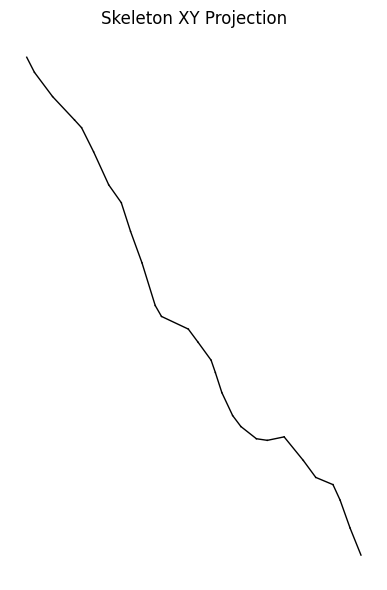

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single subplot
fig, ax = plt.subplots(figsize=(7, 6))  # Adjust size as needed

# Scale the skeleton vertices from μm to voxel space
scale_factors = np.array([18, 18, 45])
scaled_vertices = skel.vertices / scale_factors  # shape: (n_nodes, 3)
edges = skel.edges  # shape: (n_edges, 2)

# Plot edges as lines
for edge in edges:
    point1 = scaled_vertices[edge[0]]
    point2 = scaled_vertices[edge[1]]
    xs = [point1[0], point2[0]]
    ys = [point1[1], point2[1]]
    ax.plot(xs, ys, color='black', lw=1.0)

ax.set_title("Skeleton XY Projection")
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()
